<a href="https://colab.research.google.com/github/sujatasahoo/Predictive-Modeling_TreeBased-Model/blob/main/sujata_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 2, Module 4*

---

In [ ]:
%%capture
!pip install category_encoders==2.*
#import sys

# If you're on Colab:
#if 'google.colab' in sys.modules:
    #DATA_PATH = 'https://www.kaggle.com/t/b57b60bbbbe146a687a9f468d0f928bf'
    #!pip install category_encoders==2.*
    #!pip install pandas-profiling==2.*

# If you're working locally:
#else:
    #DATA_PATH = '../data/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [ ]:
directory = '/content/drive/MyDrive/WaterpumpDataset'

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')
    
    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)
    #Create age feature
    df['pump_age'] =pd.to_datetime(df['date_recorded']).dt.year - df['construction_year']
    df.drop(columns='date_recorded', inplace=True)
    #Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index 
               if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             
    df.drop(columns = ['extraction_type_group','payment_type', 'source_type','waterpoint_type_group','num_private'], inplace = True)
    
    return df
df = wrangle(fm_path=directory +'/train_features.csv', tv_path= directory+'/train_labels.csv')

X_test = wrangle(fm_path=directory+'/test_features.csv') 

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = wrangle(fm_path=directory +'/train_features.csv', tv_path= directory+'/train_labels.csv')
X_test = wrangle(fm_path=directory+'/test_features.csv') 

In [ ]:
df.shape

(47519, 26)

In [ ]:
df.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_class,waterpoint_type,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,water board,user-group,pay per bucket,soft,good,insufficient,spring,groundwater,communal standpipe,functional,15.0
510.0,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,handpump,vwc,user-group,never pay,soft,good,enough,shallow well,groundwater,hand pump,functional,NaN
14146.0,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,groundwater,other,non functional,NaN
47410.0,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,vwc,user-group,pay monthly,soft,good,insufficient,river,surface,communal standpipe,non functional,NaN
1288.0,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,vwc,user-group,pay when scheme fails,salty,salty,enough,shallow well,groundwater,other,non functional,14.0


# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [ ]:
target = 'status_group'
X = df.drop(columns = target)
y = df[target]

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =0.2, random_state = 42)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators =25, n_jobs=-1, random_state=42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake V...
                                          'mapping': groundwater    1
surface        2
unknown        3
NaN           -2
dtype: int64},
                                         {'col': 'waterpoint_type',
                    

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [ ]:
training_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.992766013415757
Validation Accuracy Score: 0.79135101010101


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


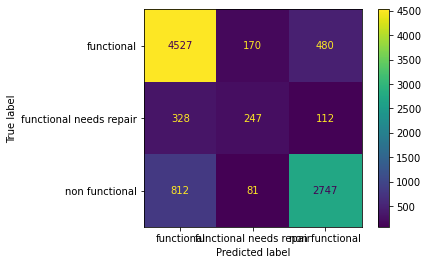

In [ ]:
# Plot 3x3 confusion matrix
plot_confusion_matrix(model,X_val,y_val,values_format = '.0f');

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [ ]:
# Print classification report 
print(classification_report(y_val,
                      model.predict(X_val),
                      target_names=['functional', 'functional needs repair', 'non functional']))

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.83      5177
functional needs repair       0.50      0.36      0.42       687
         non functional       0.82      0.75      0.79      3640

               accuracy                           0.79      9504
              macro avg       0.71      0.66      0.68      9504
           weighted avg       0.79      0.79      0.79      9504



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [ ]:
model.predict_proba(X_val)[:,-1]

array([0.08, 1.  , 0.96, ..., 0.92, 0.68, 0.68])

In [ ]:
data = {'y_val': y_val, 'y_predict_proba': model.predict_proba(X_val)[:,-1]}
results = pd.DataFrame(data)
results


,y_val,y_predict_proba
id,,
8492.0,functional needs repair,0.08
16772.0,non functional,1.00
19506.0,functional,0.96
40301.0,non functional,0.56
61519.0,functional,0.12
...,...,...
48746.0,non functional,1.00
28999.0,functional,0.00
41195.0,non functional,0.92


In [ ]:
mask = results['y_predict_proba']>.95
results[mask]

,y_val,y_predict_proba
id,,
16772.0,non functional,1.00
19506.0,functional,0.96
4125.0,non functional,1.00
12693.0,non functional,1.00
20316.0,non functional,1.00
...,...,...
3405.0,non functional,0.96
72478.0,non functional,0.96
2254.0,functional needs repair,1.00


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [ ]:
X_test_nf = results[mask]
final_df = X_test_nf.merge(df, right_index = True, left_index=True)
final_df.sort_values(by = 'population', ascending = False).head(100)


,y_val,y_predict_proba,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_class,waterpoint_type,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4930.0,non functional,0.96,NaN,1746.0,35.725617,-8.063271,Rufiji,Iringa,11,7.0,3000.0,True,VWC,True,1984.0,gravity,gravity,vwc,user-group,never pay,soft,good,dry,river,surface,communal standpipe,non functional,27.0
34440.0,non functional,0.96,20.0,260.0,38.916621,-10.472236,Ruvuma / Southern Coast,Lindi,80,53.0,2600.0,True,VWC,True,2006.0,india mark iii,handpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,groundwater,hand pump,non functional,7.0
1630.0,non functional,0.96,500.0,793.0,29.616872,-4.904015,Lake Tanganyika,Kigoma,16,4.0,2530.0,True,VWC,True,2008.0,other,other,vwc,user-group,pay monthly,soft,good,dry,shallow well,groundwater,other,non functional,5.0
59972.0,non functional,1.00,NaN,264.0,38.970196,-9.974952,Ruvuma / Southern Coast,Lindi,80,53.0,2300.0,True,VWC,False,1980.0,other,other,vwc,user-group,never pay,salty,salty,insufficient,shallow well,groundwater,other,non functional,33.0
12425.0,non functional,0.96,NaN,316.0,38.235110,-6.077886,Wami / Ruvu,Pwani,6,1.0,2000.0,True,VWC,False,1968.0,other,other,vwc,user-group,never pay,salty,salty,enough,shallow well,groundwater,other,non functional,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68025.0,non functional,0.96,20.0,1351.0,34.377202,-5.760600,Internal,Singida,13,3.0,500.0,True,VWC,False,1978.0,mono,motorpump,vwc,user-group,pay per bucket,salty,salty,enough,machine dbh,groundwater,communal standpipe multiple,non functional,35.0
7126.0,non functional,0.96,NaN,1309.0,30.502756,-3.596491,Lake Tanganyika,Kigoma,16,1.0,500.0,True,VWC,False,1990.0,other,other,vwc,user-group,unknown,soft,good,enough,machine dbh,groundwater,other,non functional,23.0
63335.0,non functional,1.00,NaN,1190.0,33.031926,-2.016070,Lake Victoria,Mwanza,19,1.0,500.0,True,VWC,True,1978.0,other,other,vwc,user-group,never pay,soft,good,insufficient,lake,surface,communal standpipe multiple,non functional,33.0


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

In [ ]:
larg_pop = final_df.sort_values(by = 'population', ascending = False).head(100)
import plotly.express as px
fig = px.scatter(x=larg_pop['latitude'], y=larg_pop['longitude'])
fig.show()
